In [3]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df = pd.read_csv('BSA-dataset-synthetic.csv', sep=';')

# Transform 'Gender' column
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'F' else 0)
df['BSA'] = df['BSA'].apply(lambda x: 1 if x == 'PS' else 0)

df.head()
df.columns


Index(['train', 'Gender', 'Nationality', 'PreEducation', 'Program', 'Year',
       'BSA', 'Course3-1', 'Course9-1', 'Course8-1', 'Course7-1', 'Course3-R',
       'Course9-R', 'Credits-B1B2', 'Course23', 'Course26', 'Course3',
       'Course16', 'Course8', 'Course9', 'Course22', 'Course7', 'Course25',
       'Course24', 'Credits-Y1'],
      dtype='object')

In [5]:
class StudentCourseResults:
    firstTryGrades = []
    resitGrades = []
    endGrades = []
    def __init__(self, course_name):
        self.course_id = course_name
        self.endgrade = None
        self.first_try_grade = None
        self.resit_grade = None
        self.blok = None

        #dummies
        self.passed_Course = None
        self.passed_Excellent = None  # 8.5-10
        self.passed_Good = None       # 7.5-8
        self.passed_Satisfactory = None  # 6.5-7
        self.passed_Sufficient = None  # 6


        self.firstTry_passed=None
        self.firstTry_present=None
        self.both_notPresent=None
        self.MaartenFactor = None

    def set_endgrade(self, endgrade):
        if np.isnan(endgrade):
            endgrade = None  
        self.endgrade = endgrade

    def set_first_try_grade(self, grade):
        if np.isnan(grade):
            grade = None
        self.first_try_grade = grade
        self.blok = 2

    def set_resit_grade(self, grade):
        if np.isnan(grade):
            grade = None  
        self.resit_grade = grade
        self.blok = 1

    def create_dummies(self):

        self.passed_Course = False
        self.passed_Excellent = False  # 8.5-10
        self.passed_Good = False       # 7.5-8
        self.passed_Satisfactory = False  # 6.5-7
        self.passed_Sufficient = False  # 6

        self.firstTry_passed = False
        self.firstTry_present = False
        self.both_notPresent = False

        if self.endgrade is None:
            self.both_notPresent = True
            return

        if 8.5 <= self.endgrade <= 10:
            self.passed_Excellent = True

        if 7.5 <= self.endgrade < 8.5:
            self.passed_Good = True

        if 6.5 <= self.endgrade < 7.5:
            self.passed_Satisfactory = True

        if self.endgrade == 6:
            self.passed_Sufficient = True

        if self.endgrade >= 5.5:
            self.passed_Course = True
        
        #Of te wel deze data hebben we niet
        if self.blok == None:
            return
        

        if self.blok == 1:
            """
            self.firstTry_passed = False
            self.firstTry_present = False
            self.both_notPresent = False
            """
            if self.first_try_grade != None:
                self.firstTry_present = True

            if self.first_try_grade != None and self.resit_grade == None and self.passed_Course ==True:
                self.firstTry_passed = True
                self.firstTry_present = True                

            if self.first_try_grade == None and self.resit_grade == None:
                self.both_notPresent = True
            

        if self.blok == 2:
            """
            self.firstTry_passed = False
            self.firstTry_present = False
            """
            if self.first_try_grade != None:
                self.firstTry_present = True    
                #dit moet dus gefixed worden
                if self.first_try_grade >= 5.5:
                    self.firstTry_passed= True 


    def __print__(self):
        string = "mooi man"
        return string
    
    def for_df_column(self):
        # Example usage:
        courses_data = {}
        
        if(self.passed_Course == None):
            return courses_data

        if self.blok == None:
            courses_data = {
                "x_"+self.course_id + "_Endgrade": self.endgrade,
                "x_"+self.course_id + "_PassedCourse": int(self.passed_Course), 
                "x_"+self.course_id + "_passed_Excellent": int(self.passed_Excellent),
                "x_"+self.course_id + "_passed_Good": int(self.passed_Good),
                "x_"+self.course_id + "_passed_Satisfactory": int(self.passed_Satisfactory),
                "x_"+self.course_id + "_passed_Sufficient": int(self.passed_Sufficient),                               
            }
        elif self.blok == 1:
            courses_data = {
                "1_"+self.course_id + "_Endgrade": self.endgrade,
                "1_"+self.course_id + "_FirstTryPassed": int(self.firstTry_passed),
                "1_"+self.course_id + "_FirstTryPresent": int(self.firstTry_present),
                "1_"+self.course_id + "_Both_notPresent": int(self.both_notPresent),

                "1_"+self.course_id + "_PassedCourse": int(self.passed_Course),
                "1_"+self.course_id + "_passed_Excellent": int(self.passed_Excellent),
                "1_"+self.course_id + "_passed_Good": int(self.passed_Good),
                "1_"+self.course_id + "_passed_Satisfactory": int(self.passed_Satisfactory),
                "1_"+self.course_id + "_passed_Sufficient": int(self.passed_Sufficient),


            }         
        elif self.blok == 2:
            courses_data = {
                "2_"+self.course_id + "_Endgrade": self.endgrade,
                "2_"+self.course_id + "_FirstTryPassed": int(self.firstTry_passed),
                "2_"+self.course_id + "_FirstTryPresent": int(self.firstTry_present),
                "2_"+self.course_id + "_PassedCourse": int(self.passed_Course),
                "2_"+self.course_id + "_passed_Excellent": int(self.passed_Excellent),
                "2_"+self.course_id + "_passed_Good": int(self.passed_Good),
                "2_"+self.course_id + "_passed_Satisfactory": int(self.passed_Satisfactory),
                "2_"+self.course_id + "_passed_Sufficient": int(self.passed_Sufficient),
            }         
        return courses_data

# Create an empty dictionary to store Course objects

# Create an empty list to store DataFrames for each row
new_dfs = []

# Iterate over each row in the original DataFrame
for i in range(len(df)):
    courses = {}
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column represents a course
        if column.startswith('Course'):
            # Extract the course name
            course_name = column.split('-')[0]
            # Check if the course object exists in the dictionary
            if course_name not in courses:
                # If not, create a new Course object
                course = StudentCourseResults(course_name)
                courses[course_name] = course
            else:
                # If it exists, retrieve the existing Course object
                course = courses[course_name]

            # Get the endgrade for the current course from the DataFrame
            endgrade = df.loc[i, column]

            # Set the endgrade, first try grade, or resit grade based on the column name
            if '-1' in column:
                course.set_first_try_grade(endgrade)
            elif '-R' in column:
                course.set_resit_grade(endgrade)
            else:
                course.set_endgrade(endgrade)

    # Create an empty dictionary to store the data for the current row
    row_data = {}
    
    # Populate the dictionary with data for the current row
    for course_name, course in courses.items():
        course.create_dummies()
        row_data.update(course.for_df_column())


    # Create a DataFrame from the row data
    new_df = pd.DataFrame([row_data])

    # Append the new DataFrame to the list
    new_dfs.append(new_df)

# Concatenate all DataFrames in the list to create the final DataFrame
final_df = pd.concat(new_dfs, ignore_index=True)




C:\Users\maart\AppData\Local\Temp\ipykernel_20116\2810321101.py:205: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(new_dfs, ignore_index=True)


In [6]:
final_df

,1_Course3_Endgrade,1_Course3_FirstTryPassed,1_Course3_FirstTryPresent,1_Course3_Both_notPresent,1_Course3_PassedCourse,1_Course3_passed_Excellent,1_Course3_passed_Good,1_Course3_passed_Satisfactory,1_Course3_passed_Sufficient,1_Course9_Endgrade,...,x_Course25_passed_Excellent,x_Course25_passed_Good,x_Course25_passed_Satisfactory,x_Course25_passed_Sufficient,x_Course24_Endgrade,x_Course24_PassedCourse,x_Course24_passed_Excellent,x_Course24_passed_Good,x_Course24_passed_Satisfactory,x_Course24_passed_Sufficient
0,2.5,0,1,0,0,0,0,0,0,NaN,...,0,0,0,0,NaN,0,0,0,0,0
1,3.5,0,1,0,0,0,0,0,0,5.0,...,0,0,0,0,4.0,0,0,0,0,0
2,2.5,0,1,0,0,0,0,0,0,1.5,...,0,0,0,0,NaN,0,0,0,0,0
3,5.0,0,1,0,0,0,0,0,0,1.5,...,0,0,0,0,NaN,0,0,0,0,0
4,NaN,0,0,1,0,0,0,0,0,NaN,...,0,0,0,0,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,8.0,1,1,0,1,0,1,0,0,7.0,...,0,1,0,0,9.5,1,1,0,0,0
57,6.5,1,1,0,1,0,0,1,0,2.5,...,0,0,0,0,7.0,1,0,0,1,0
58,6.5,1,1,0,1,0,0,1,0,1.5,...,1,0,0,0,7.5,1,0,1,0,0
59,6.5,1,1,0,1,0,0,1,0,8.0,...,0,0,1,0,7.5,1,0,1,0,0


In [7]:
# Filter columns in df that do not contain the substring 'Course'
non_course_columns_df = df.loc[:, ~df.columns.str.contains('Course')]

# Concatenate the non-course columns from the original DataFrame with the final DataFrame
merged_df = pd.concat([non_course_columns_df, final_df], axis=1)



In [8]:
# Save the merged DataFrame to an Excel file
merged_df.to_excel('merged_data.xlsx', index=False)

# Print a message to confirm the file has been saved
print("Merged data has been saved to 'merged_data.xlsx")

In [ ]:
columns_to_drop = ['train', 'PreEducation', 'Program', 'Year', 'BSA', 'Credits-B1B2', 'Credits-Y1']


df_Clustering = merged_df.dropna(axis=1).drop(columns=columns_to_drop)

# Create dummy variables
nationality_dummies = pd.get_dummies(df_Clustering['Nationality'], prefix='Nationality',dtype='int')

# Concatenate the dummy variables with the original DataFrame
df_Clustering = pd.concat([df_Clustering, nationality_dummies], axis=1)

# Drop the original 'Nationality' column
df_Clustering = df_Clustering.drop(columns=['Nationality'])


# # Assuming df is your DataFrame
# columns_to_drop = df_Clustering.filter(regex='^x_').columns
# df_Clustering = df_Clustering.drop(columns=columns_to_drop)
# df_Clustering


,Gender,1_Course3_FirstTryPassed,1_Course3_FirstTryPresent,1_Course3_Both_notPresent,1_Course3_PassedCourse,1_Course3_passed_Excellent,1_Course3_passed_Good,1_Course3_passed_Satisfactory,1_Course3_passed_Sufficient,1_Course9_FirstTryPassed,...,2_Course7_passed_Sufficient,Nationality_Afrika,Nationality_Azie,Nationality_EU,Nationality_Europa,Nationality_Mid-Zuid-Amerika,Nationality_Nederland,Nationality_Noord-Amerika,Nationality_Oceanie,Nationality_Onbekend
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,1,1,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0
57,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
58,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
59,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


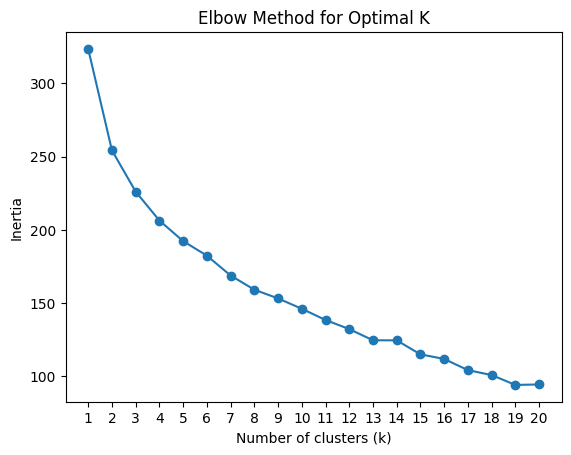

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import umap

import numpy as np


def kmeans():
    inertia = []
    for i in range(1, 21):
        kmeans = KMeans(n_clusters=i, n_init=10)
        kmeans.fit(df_Clustering.dropna(axis=1))
        inertia.append(kmeans.inertia_)

    # Plot the elbow method
    plt.plot(range(1, 21), inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')

    plt.xticks(range(1,21))
    plt.show()

kmeans()



In [ ]:
# Use UMAP for dimensionality reduction to 2D

reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(df_Clustering)

# Apply KMeans with the optimal number of clusters


kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(df_Clustering)



In [ ]:
import plotly.graph_objects as go

# Specify the columns you want to include in hover data
hover_columns = ['Credits-Y1', 'Nationality', "Gender", "Credits-B1B2"]

# Create hover text by concatenating values from specified columns
hover_text = merged_df.apply(lambda row: '<br>'.join(f"{col}: {row[col]}" for col in hover_columns), axis=1)

# Define marker symbols based on BSA values
marker_symbols = ['cross' if bsa == 0 else 'square' for bsa in merged_df['BSA']]

# Create a scatter plot trace with hover data
scatter_trace = go.Scatter(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    mode='markers',
    marker=dict(
        color=cluster_labels,
        colorscale='BlueRed',
        size=10,
        symbol=marker_symbols,  # Set the marker symbols
        colorbar=dict(title='Cluster')
    ),
    text=hover_text  # Set the hover text
)

# Create a layout
layout = go.Layout(
    title='UMAP 2-D representation of document embeddings with K-Means clustering',
    xaxis=dict(title='UMAP Dimension 1'),
    yaxis=dict(title='UMAP Dimension 2'),
    width=1600,  # Set width of the figure
    height=1200,  # Set height of the figure

)

# Create a figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the interactive plot
fig.show()


from sklearn.metrics import confusion_matrix

true_labels = np.where(merged_df["BSA"] == 1, 0, 1)

print(len(true_labels))
print(len(cluster_labels))
# Assuming cluster_labels are the predicted cluster labels obtained from the clustering algorithm
# Compute the confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)

print("Confusion Matrix:")
print(cm)


61
61
Confusion Matrix:
[[31  6]
 [ 4 20]]


In [ ]:
merged_df["BSA"]

0     0
1     0
2     0
3     0
4     0
     ..
56    1
57    0
58    1
59    1
60    1
Name: BSA, Length: 61, dtype: int64

In [ ]:
import statsmodels.api as sm

# Define the predictors (independent variables)
predictors = ['1_Course3_PassedCourse',
              #'1_Course3_FirstTryPassed',
              '1_Course3_Both_notPresent',
              '1_Course9_PassedCourse', 
              #'1_Course9_FirstTryPassed',
              '1_Course9_Both_notPresent',
              
              '2_Course8_FirstTryPassed',
               
              '2_Course7_FirstTryPassed']

# Add a constant term for the intercept
X = sm.add_constant(merged_df[predictors])

# Define the target variable
y = merged_df['Credits-Y1']
model = sm.OLS(y, X)

# y = merged_df['BSA']
# model = sm.Logit(y, X)

result = model.fit()
print(result.summary())



                            OLS Regression Results                            
Dep. Variable:             Credits-Y1   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     30.86
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           8.85e-16
Time:                        14:56:54   Log-Likelihood:                -226.45
No. Observations:                  61   AIC:                             466.9
Df Residuals:                      54   BIC:                             481.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 